In [1]:
import os

os.chdir("../../../..")

os.getcwd()

'c:\\Users\\mquick\\Documents\\zeitgeist blog\\projects\\geopolitical_proximity'

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from utils.tools import BQConnector
from utils.impute import Imputer
from utils.types.variables import democratic
from bq.bq_tables import node_data

In [3]:
vdem = pd.read_csv("./notebooks/nodes/data/vdem.csv")

In [4]:
vdem.head(1)

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,...,v2xex_elecleg,v2xps_party,v2xps_party_codelow,v2xps_party_codehigh,v2x_divparctrl,v2x_feduni,v2xca_academ,v2xca_academ_codelow,v2xca_academ_codehigh,v2xca_academ_sd
0,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1789,2023,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [4]:
vdem_small = vdem[["year", "country_text_id", "v2x_polyarchy"]]

In [5]:
bq = BQConnector()

In [6]:
node_ids = bq.get_node_ids()

In [7]:
nodes_dem_df = vdem_small\
    .merge(node_ids, left_on="country_text_id", right_on="iso3", how="right")\
    .drop("country_text_id", axis=1)\
    .rename(columns={"v2x_polyarchy":"value"})

In [8]:
nodes_dem_df.loc[nodes_dem_df["value"].notna(), "is_imputed"] = False

In [9]:
imputer = Imputer(group_by_col="iso3")

In [10]:
dem_missing = imputer.pct_completeness_by_group(dataframe=nodes_dem_df, value_col="value")

In [11]:
dem_missing[dem_missing["complete_pct"]==0]

,iso3,complete_pct
3,AND,0.0
7,ATG,0.0
18,BHS,0.0
21,BLZ,0.0
25,BRN,0.0
46,DMA,0.0
59,FSM,0.0
69,GRD,0.0
91,KIR,0.0
92,KNA,0.0


In [12]:
interpolated_dem_df = imputer.interpolate_values(dataframe=nodes_dem_df)

In [27]:
complete_dem_df = interpolated_dem_df.dropna(subset=["value"])

<Axes: xlabel='year', ylabel='value'>

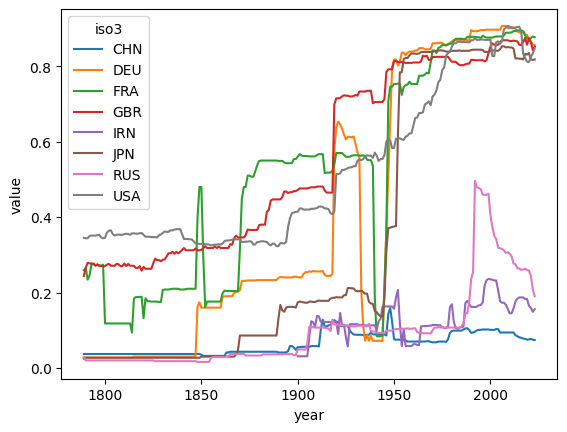

In [14]:
sns.lineplot(data=complete_dem_df[complete_dem_df["iso3"].isin(["USA", "FRA", "GBR", "RUS", "CHN", "IRN", "JPN", "DEU"])],
             x="year", y="value", hue="iso3"
             )

In [28]:
complete_dem_df["value_norm"] = complete_dem_df.groupby("year")["value"].transform(
            lambda x: (x - x.mean()) / x.std()
        )

<Axes: xlabel='year', ylabel='value_norm'>

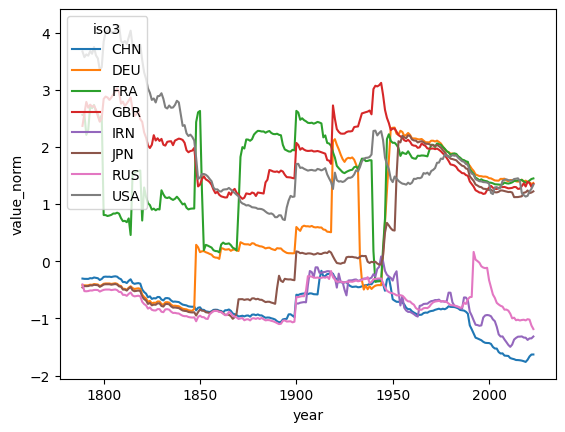

In [16]:
sns.lineplot(data=complete_dem_df[complete_dem_df["iso3"].isin(["USA", "FRA", "GBR", "RUS", "CHN", "IRN", "JPN", "DEU"])],
             x="year", y="value_norm", hue="iso3"
             )

In [67]:
node_data.schema

[SchemaField('node_id', 'INT64', 'REQUIRED', None, None, (), None),
 SchemaField('variable_id', 'INT64', 'REQUIRED', None, None, (), None),
 SchemaField('value', 'FLOAT64', 'NULLABLE', None, None, (), None),
 SchemaField('value_norm', 'FLOAT64', 'NULLABLE', None, None, (), None),
 SchemaField('is_imputed', 'BOOL', 'REQUIRED', None, None, (), None),
 SchemaField('is_latest', 'BOOL', 'REQUIRED', None, None, (), None),
 SchemaField('date_added', 'DATETIME', 'REQUIRED', None, None, (), None),
 SchemaField('year', 'INT64', 'NULLABLE', None, None, (), None)]

In [29]:
complete_dem_df.loc[complete_dem_df["is_imputed"].isna(), "is_imputed"] = True

In [30]:
complete_dem_df = complete_dem_df.assign(
    variable_id = democratic.id,
    date_added = datetime.now()
).drop("iso3", axis=1)

In [31]:
complete_dem_df["is_latest"] = np.where(complete_dem_df["year"]==2023, True, False)

In [33]:
# bq.upload_to_bq(dataframe=complete_dem_df, variable=democratic)

True